In [1]:
import numpy as np
import pandas as pd
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(1,'D:\\thesis-main\codes')
import time

from package.loadDb import *
from package.featureSelection_TENSORIZED import *
from package.featureSelection_TEMPORAL_PAGERANK import *
from package.featureSelection_SICE import *

from package.trmf import *
from package.trmf_regressor import *

from package.regressors import *


In [2]:
# import kaggle dataset
address = "..\database\kaggleDataFrame"

data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")

# data_with_target=data_with_target.iloc[2000:4000]

data_without_target = data_with_target.drop(['DEMAND'],axis=1)

target=data_with_target.iloc[:,-1]
print("data with target size = ",data_with_target.shape )


# # data with target column
# address = "..\database\stock market dataset"
# data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
# # data_with_target=data_with_target.iloc[:10000]
# data_without_target = data_with_target.drop(['TARGET'],axis=1)
# # data_without_target=data_with_target.iloc[:,:-1]
# target=data_with_target.iloc[:,-1]

data with target size =  (46968, 11)


In [3]:
data_without_target.shape

(46968, 10)

In [4]:
1602808/2000

801.404

In [5]:
# plt.plot(list(target[:20]))

In [11]:
#segment sizes
interval=2000
testSize=500
#energy of pca to compute number of components
tol=.89


In [12]:
#dictionary contains rmse of test set of each segment for all methods
dict_rmse={}
dict_runtime={}

PCA

In [13]:
counter=0
pca_list=[]
num_comp_list=[]
runtime=[]
# while counter+interval <= data_without_target.shape[0]:
for i in range(data_without_target.shape[0]//interval):
    start_index=i*interval
    end_index=start_index+interval

    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    st = time.time()
    X_transformed,eigenvalues=compute_pca(X_datacut,num_comp=None)
    et = time.time()
    num_comp=energy(eigenvalues,tol)
    X_pca=X_transformed[:,:num_comp]
    
    pca_rmse=xgboost_reg_error(X_pca,Y_datacut,testSize)

    pca_list.append(pca_rmse)##########################
    num_comp_list.append(num_comp)##########################

    elapsed_time = et - st
    runtime.append(elapsed_time)
    

    # counter+=interval
    
dict_rmse['PCA']=pca_list
dict_runtime["PCA_runtime"]=runtime

In [14]:
num_comp_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]

TRMF

In [15]:
# trmf parameters..............................................
lags = [1,30]
# K = 4######### changes besed on pca energy
lambda_f = 1.
lambda_x = 1
lambda_w = 1.
alpha = 1000.
eta = 1.
max_iteration=10000
# num_comp=K

In [16]:
trmf_rmse_list=[]
runtime=[]

counter=0
i=0
# while counter+interval <= data_without_target.shape[0]:
for j in range(data_without_target.shape[0]//interval):
    start_index=j*interval
    end_index=start_index+interval
    
    K=num_comp_list[i]

    data=data_without_target.to_numpy().T

    data=data[:,start_index:end_index]
    target_cut=target.iloc[start_index:end_index]

    T_train = data.shape[1]
    st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    data_normalized =normalized_data(data, T_train, 0, normalize=True)

    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta)
    model.fit(data_normalized, max_iter = max_iteration)
    et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    elapsed_time = et - st
    runtime.append(elapsed_time)

    # get reduced data
    new_features=model.X.T
    
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
    trmf_rmse_list.append(rmse)
    # counter+=interval
    i=i+1
    print(i,K)
    print("----------------------------------------------------------------------------")
dict_rmse['trmf_rmse']=trmf_rmse_list
dict_runtime["TRMF_runtime"]=runtime


1 1
----------------------------------------------------------------------------
2 1
----------------------------------------------------------------------------
3 1
----------------------------------------------------------------------------
4 1
----------------------------------------------------------------------------
5 1
----------------------------------------------------------------------------
6 1
----------------------------------------------------------------------------
7 1
----------------------------------------------------------------------------
8 1
----------------------------------------------------------------------------
9 1
----------------------------------------------------------------------------
10 1
----------------------------------------------------------------------------
11 1
----------------------------------------------------------------------------
12 1
----------------------------------------------------------------------------
13 1
--------------------

TEMPORAL PAGE RANK FEATURE SELECTION

In [17]:
window_size_list=[2,3,5,7,10,30]#

In [19]:


dict_mse_tpr={}
dict_runtime_tpr={}
for window_size in window_size_list :
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_without_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]

        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]


        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        
        arr=create_graph_details(X_datacut,window_size)
        a=featureSelection_tpr(arr,X_datacut.shape[1],num_comp)
       
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)


        mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)

        method_list.append(mse_tpr)
        #     print( "method_list",method_list)
        i=i+1
        print(j)
        print("----------------------------------------------------------------------------")
        # counter+=interval
    dict_mse_tpr["Temp-PR win={}".format(window_size)]=method_list
    dict_runtime_tpr["Temporal-PR win={}".format(window_size)]=runtime


dataframe_1 = pd.DataFrame(dict_mse_tpr)
dict_rmse['temp_PR_rmse']=list(dataframe_1.min(axis=1))
df_time_1=pd.DataFrame(dict_runtime_tpr)
dict_runtime["Temporal_pr_runtime"]=list(df_time_1.mean(axis=1))


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


22
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


22
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


22
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


22
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


22
----------------------------------------------------------------------------
0
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


1
----------------------------------------------------------------------------
2
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


3
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


4
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


5
----------------------------------------------------------------------------
6
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


7
----------------------------------------------------------------------------
8
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


9
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


10
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


11
----------------------------------------------------------------------------
12
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


13
----------------------------------------------------------------------------
14
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


15
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


16
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


17
----------------------------------------------------------------------------
18
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


19
----------------------------------------------------------------------------
20
----------------------------------------------------------------------------


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_10576\349924479.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)


21
----------------------------------------------------------------------------
22
----------------------------------------------------------------------------


In [20]:
dict_mse_sice={}
dict_runtime_sice={}

for window_size in window_size_list:
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_with_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]


        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]
        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>

        selected_features_index=featureSelection(X_datacut,window_size)
        
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)
        
        selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
        mse_sice=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)
        

        method_list.append(mse_sice)
        #     print( "method_list",method_list)
        i=i+1
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict_mse_sice["sice win={}".format(window_size)]=method_list
    dict_runtime_sice["Static-PR win={}".format(window_size)]=runtime

dataframe_2 = pd.DataFrame(dict_mse_sice)
dict_rmse['static_PR_rmse']=list(dataframe_2.min(axis=1))
df_time_2=pd.DataFrame(dict_runtime_sice)
dict_runtime["Static_pr_runtime"]=list(df_time_2.mean(axis=1))

number of windows= 1000 
size of windows = 2
[1.8956047619464065, 1.8956031295208635, 1.8956034636757695, 1.8956066972656944, 1.894681376288231, 1.894207470533881, 1.895421469012302, 1.8954021823034322, 1.8922974022051426, 1.8955563417135277] [3, 0, 2, 1, 9, 6, 7, 4, 5, 8]
0.0
----------------------------------------------------------------------------
number of windows= 1000 
size of windows = 2
[1.8956154524156519, 1.8956142141614611, 1.8956162243374948, 1.8956164248547207, 1.8947202850692477, 1.8940033018533202, 1.8954549035082102, 1.8954549035082102, 1.892322389185165, 1.895565573621654] [3, 2, 0, 1, 9, 6, 7, 4, 5, 8]
1.0
----------------------------------------------------------------------------
number of windows= 1000 
size of windows = 2
[1.8956176253793258, 1.8956134020384905, 1.8956151101257483, 1.8956155052312824, 1.8947132207009978, 1.8939930267616687, 1.895466407142873, 1.895466407142873, 1.8923199778061859, 1.8955628596879728] [0, 3, 2, 1, 9, 6, 7, 4, 5, 8]
2.0
----------

<AxesSubplot: title={'center': 'num_comp=.'}, xlabel='dataframe segments', ylabel='RMSE'>

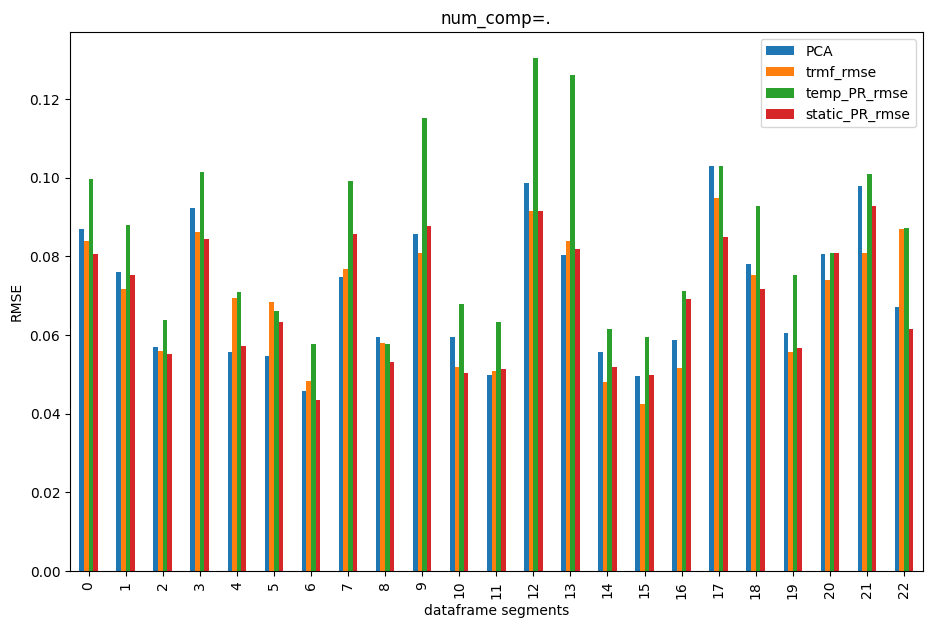

In [21]:
   
dataframe = pd.DataFrame(dict_rmse)
plt.rcParams["figure.figsize"] = [11,7]
dataframe.plot(kind="bar",title="num_comp={}".format("."),ylabel='RMSE',xlabel="dataframe segments")

<AxesSubplot: title={'center': '.'}, xlabel='dataframe segments', ylabel='Time'>

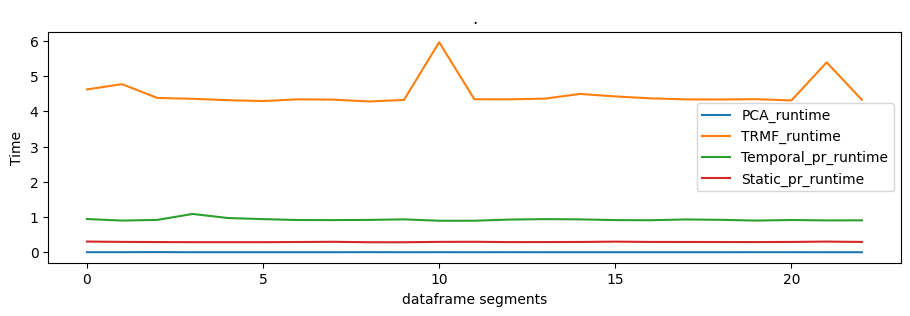

In [22]:
time_dataframe = pd.DataFrame(dict_runtime)
plt.rcParams["figure.figsize"] = [11,3]
time_dataframe.plot(kind="line",title="{}".format("."),ylabel='Time',xlabel="dataframe segments")


In [ ]:
dataframe.mean()

PCA               0.064049
trmf_rmse         0.059762
temp_PR_rmse      0.058650
static_PR_rmse    0.065891
dtype: float64

In [19]:
num_comp_list

[9]

In [20]:
dataframe.head(30)

,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.064049,0.059762,0.05865,0.065891


In [21]:
dataframe.loc['Var'] =list(dataframe.var())
dataframe.loc['Mean'] =list(dataframe.mean())
dataframe.loc['Min'] =list(dataframe.min())
dataframe.loc['Max'] =list(dataframe.max())

In [22]:
dataframe.head(30)


,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.064049,0.059762,0.05865,0.065891
Var,NaN,NaN,NaN,NaN
Mean,0.064049,0.059762,0.05865,0.065891
Min,0.064049,0.059762,0.05865,0.065891
Max,0.064049,0.059762,0.05865,0.065891


In [23]:
# name="kaggle-energy={}".format(tol)
# time_dataframe.to_excel("time-{}.xlsx".format(name))  
# dataframe.to_excel("RMSE-{}.xlsx".format(name))